In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import dask
import cftime
import random
import glob
import matplotlib.gridspec as gs
import pint_xarray
import cf_xarray as cfxr
from eofs.xarray import Eof

In [2]:
from dask.distributed import Client, LocalCluster
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40937 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/40937/status,
Dashboard: /proxy/40937/status,Workers: 7
Total threads: 14,Total memory: 63.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:40177,Workers: 7
Dashboard: /proxy/40937/status,Total threads: 14
Started: Just now,Total memory: 63.00 GiB
Comm: tcp://127.0.0.1:39449,Total threads: 2
Dashboard: /proxy/46679/status,Memory: 9.00 GiB
Nanny: tcp://127.0.0.1:34101,


In [3]:
#load observational SST
hadsst = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/HadISST_sst.nc", chunks = {'time':12}).sst
hadsst = hadsst.sortby(hadsst.latitude, ascending=True)
#rename coords
hadsst =hadsst.sel(time = slice("1950-01-01", "2022-12-31"))
hadsst = hadsst.compute()

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x14c70efe2400>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/utils_perf.py", line 176, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x154a67b18460>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distributed/utils_perf.py", line 176, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x14978e1e4460>>
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.10/lib/python3.9/site-packages/distribu

KeyboardInterrupt: 

In [ ]:
hadsst1 = xr.where(hadsst == -1000, np.nan, hadsst)

In [ ]:
def roll_lon(df):
    df.coords['longitude'] = (df.coords['longitude']+360) % 360 #- 180
    df = df.sortby(df.longitude)
    return df

In [ ]:
hadsst1 = roll_lon(hadsst1)

In [ ]:
hadsst1[0].plot()

In [ ]:
def ssta(DS):
    #DEFINE SSTA RELATIVE TO 1990-2005 MEAN
    clim = DS.sel(time = slice("1990-01-01", "2005-12-31")).groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")

In [ ]:
def EP_CP_index(DS):
    """
    Calculate the Eastern Pacific (EP) and Central Pacific (CP) indices 
    based on the first two principal components (PCs) from an EOF analysis 
    of sea surface temperature anomalies (SSTAs), with adjustments based 
    on the sign of the EOFs at a specific location (250° longitude, 0° latitude).

    The function first computes the SST anomalies over a specified region 
    (140° to 280° longitude, -15° to 15° latitude) and then performs an EOF analysis.
    The sign of the first two EOFs at the specified location is used to adjust
    the sign of the corresponding PCs. The EP and CP indices are then calculated 
    from these adjusted PCs.

    Parameters:
    -----------
    DS : xarray.Dataset
        A dataset containing sea surface temperature data. The dataset should 
        include 'xt_ocean' and 'yt_ocean' coordinates.

    Returns:
    --------
    tuple of xarray.DataArray
        A tuple containing the EP and CP indices as xarray.DataArray objects.

    Notes:
    ------
    - The function assumes that the input dataset 'DS' has the necessary 
      fields and coordinates for the EOF analysis.
    - The SST anomaly is calculated internally within the function; 
      hence, 'DS' should contain absolute SST values.
    - The function uses the 'eofs.xarray' package for EOF analysis.
    - The weights for the EOF analysis are calculated as the square root 
      of the cosine of latitude.

    Example:
    --------
    >>> ds = xr.open_dataset('sst_data.nc')
    >>> ep_index, cp_index = EP_CP_index(ds)
    >>> print(ep_index, cp_index)
    """
    # Compute SST anomaly and select region
    DS = roll_lon(DS)
    sst_anom = ssta(DS)
    sst_anom = sst_anom.sel(longitude=slice(140, 280), latitude=slice(-15, 15))
    coslat = np.cos(np.deg2rad(sst_anom.coords['latitude'].values))
    wgts = np.sqrt(coslat)[..., np.newaxis]

    # EOF analysis
    solver = Eof(sst_anom, weights=wgts)
    pcs = solver.pcs(npcs=2, pcscaling=1)

    # Calculate EOFs
    eofs_ = solver.eofsAsCovariance(neofs=4)
    
    # Check sign of EOFs at specific location
    eof1_val = eofs_.sel(mode=0, longitude=250, latitude=0, method="nearest").values
    eof2_val = eofs_.sel(mode=1, longitude=250, latitude=0, method="nearest").values

    # Adjust PCs based on EOF sign
    if eof1_val < 0:
        pc1= -pcs[:, 0]
    else:
        pc1 = pcs[:, 0]
    if eof2_val < 0:
        pc2 = pcs[:, 1]
    else:
        pc2 = -pcs[:, 1]

    # Calculate indices
    EP = (pc1 - pc2) / np.sqrt(2)
    CP = (pc1 + pc2) / np.sqrt(2)

    return EP, CP

In [ ]:
def EP_CP_events(DS):
    EP, CP = EP_CP_index(DS)
    # Select SON seasons into a timeseries
    E_DJF = EP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    C_DJF = CP.resample(time='QS-DEC').mean(dim="time").groupby('time.season')["DJF"]
    #get the Ep and CP events
    TH_E = E_DJF.std()
    EP_e = E_DJF.where(E_DJF >1* TH_E.values).dropna(dim="time")
    TH_C = C_DJF.std()
    CP_e = C_DJF.where(C_DJF >1* TH_C.values).dropna(dim="time")
    return EP_e.groupby('time.year').mean("time").year, CP_e.groupby('time.year').mean("time").year

In [ ]:
def get_EPCP_times(ds_sst, ds_var=None):

    EP, CP = EP_CP_events(ds_sst)
    
    # Calculate the mean year for LN and EN
    EP_E = EP
    CP_E = CP
    
    # If ds_var is not provided, use ds_sst
    if ds_var is None:
        ds_var = ssta(ds_sst)
    
        
    # Initialize empty lists to store subsets
    epos_list = []
    epos_list2 = []
    cpos_list = []
    cpos_list2 = []    
    # Loop through each year group in ds_var and subset based on specific years in LN and EN
    for year, group in ds_var.groupby("time.year"):
        try:
            if year in EP_E:
                pos_subset = group
                epos_list.append(pos_subset)
                epos_list2.append(ds_var.groupby("time.year")[year+1])
            elif year in CP_E:
                pos_subset = group
                cpos_list.append(pos_subset)
                cpos_list2.append(ds_var.groupby("time.year")[year+1])
            else:
                pass
        except:
            print("some error, probs year is no in timeseries", year)
    
    # Concatenate subsets into a single DataArray
    esubset_ds_pos = xr.concat(epos_list, dim='time')
    esubset_ds_pos2 = xr.concat(epos_list2, dim='time')
    
    csubset_ds_pos = xr.concat(cpos_list, dim='time')
    csubset_ds_pos2 = xr.concat(cpos_list2, dim='time')
    
    #now groupby month to get the monhtly evolution of EP and CP events
    esubset_ds_pos = esubset_ds_pos.groupby("time.month").mean("time")
    esubset_ds_pos2 = esubset_ds_pos2.groupby("time.month").mean("time")
    csubset_ds_pos = csubset_ds_pos.groupby("time.month").mean("time")
    csubset_ds_pos2 = csubset_ds_pos2.groupby("time.month").mean("time")
       
    return esubset_ds_pos, esubset_ds_pos2, csubset_ds_pos, csubset_ds_pos2

In [ ]:
ep1, ep2, cp1, cp2 = get_EPCP_times(hadsst1)

In [ ]:
#now erode the coastlines a bit and use the 

In [ ]:
def erode_coastlines(da):
    # Create a mask of NaN values
    nan_mask = np.isnan(da[0])
    # Create a mask of ocean points (i.e., non-NaN)
    ocean_mask = (~nan_mask)
    # Create a mask of points that are NaN and surrounded by at least one ocean point
    replace_mask = nan_mask & (
        ocean_mask.shift(latitude=1, fill_value=False) | 
        ocean_mask.shift(latitude=-1, fill_value=False) | 
        ocean_mask.shift(longitude=1, fill_value=False) | 
        ocean_mask.shift(longitude=-1, fill_value=False) | 
        ocean_mask.shift(latitude=1, longitude=1, fill_value=False) | 
        ocean_mask.shift(latitude=1, longitude=-1, fill_value=False) | 
        ocean_mask.shift(latitude=-1, longitude=-1, fill_value=False) | 
        ocean_mask.shift(latitude=-1, longitude=1, fill_value=False)
    )
    #create values of rolling mean of the area surrounding the points
    rep = da.rolling(latitude=3, longitude=3, center=True, min_periods=1).mean()
    #mask da with averaged points
    da_eroded = da.where(~replace_mask, rep)
    return da_eroded

In [ ]:
ep1 = erode_coastlines(ep1)
ep2 = erode_coastlines(ep2)
cp1 = erode_coastlines(cp1)
cp2 = erode_coastlines(cp2)

In [ ]:
def roll_lon2ACCESS(df):
    # Make a copy of the input array
    df_copy = df.copy(deep=True)
    
    # Modify longitude for the copied array
    df_copy.coords['longitude'] = (df_copy.coords['longitude']-180)# %360
    df_copy = df_copy.sortby(df_copy.longitude)
    
    return df_copy

In [ ]:
ep1 = roll_lon2ACCESS(ep1)
ep2 = roll_lon2ACCESS(ep2)
cp1 = roll_lon2ACCESS(cp1)
cp2 = roll_lon2ACCESS(cp2)

In [ ]:
#now lets load in the SST climatology and add the composites to get the evolution of model_clim + EP(CP) El Nino

In [ ]:
model_clim = xr.open_dataset("/g/data/e14/sm2435/Pacemaker/global_sst_restoring_cm000_climatology_0951-1150.nc", decode_cf=False)

In [ ]:
#write regridder

In [ ]:
grid_in = xe.util.grid_2d(0.0, 360.0, 1.0, -90.0, 90.0, 1.0)

In [ ]:
grid_in

In [ ]:
ds_out = xr.Dataset(
    {
        "lat": (["lat"], model_clim.GRID_Y_T.values, {"units": "degrees_north"}),
        "lon": (["lon"], model_clim.GRID_X_T.values, {"units": "degrees_east"}),
    }
)
ds_out


In [ ]:
RG = xe.Regridder(grid_in, ds_out, method = 'conservative_normed', periodic=True)

In [ ]:
RG

In [ ]:
def regrid_meta(da):
    da = RG(da)
    da = da.rename({"lon": "GRID_X_T", "lat": "GRID_Y_T", "month": "TIME"})
    da = da.expand_dims(dim =  {"DEPTH1_1":model_clim.DEPTH1_1})
    da = da.assign_coords({"GRID_X_T": model_clim.GRID_X_T, "GRID_Y_T": model_clim.GRID_Y_T, "TIME":model_clim.TIME, "DEPTH1_1":model_clim.DEPTH1_1})
    da = da.assign_attrs({"long_name": "Climatology SST restoring", "units": "degrees K", "valid_range": np.array([-10., 500.], dtype=np.float32)})
    #da = da.to_dataset(name = 'temp')
    #da = da[["TIME", "DEPTH1_1", "GRID_Y_T", "GRID_X_T", "temp"]]
    return da

In [ ]:
#now lets regrid and save our SST restroing files

In [ ]:
EP1 = regrid_meta(ep1)
EP2 = regrid_meta(ep2)
CP1 = regrid_meta(cp1)
CP2 = regrid_meta(cp2)

In [ ]:
def mask_jan_apr(da):
    da = da.where((da.TIME > 4*30) | da.isnull(), other=0)
    return da

In [ ]:
#mask jan-apr for year 1

In [ ]:
EP1 = mask_jan_apr(EP1)
CP1 = mask_jan_apr(CP1)


In [ ]:
EP1[0,0].plot()

In [ ]:
#now add to model cliamtology and assign attributes

In [ ]:
EP1_clim = EP1+model_clim.temp
EP2_clim = EP2+model_clim.temp
CP1_clim = CP1+model_clim.temp
CP2_clim = CP2+model_clim.temp

In [ ]:
EP1_clim = EP1_clim[0].drop("DEPTH1_1")

In [ ]:
EP2_clim = EP2_clim[0].drop("DEPTH1_1")

In [ ]:
EP1_clim = EP1_clim.rename({"GRID_X_T":"longitude", "GRID_Y_T":"latitude", "TIME":"month"})
EP2_clim = EP2_clim.rename({"GRID_X_T":"longitude", "GRID_Y_T":"latitude", "TIME":"month"})


In [ ]:
CP1_clim = CP1_clim[0].drop("DEPTH1_1")

In [ ]:
CP2_clim = CP2_clim[0].drop("DEPTH1_1")

In [ ]:
CP1_clim = CP1_clim.rename({"GRID_X_T":"longitude", "GRID_Y_T":"latitude", "TIME":"month"})
CP2_clim = CP2_clim.rename({"GRID_X_T":"longitude", "GRID_Y_T":"latitude", "TIME":"month"})


In [ ]:
def ssta(DS):
    clim = DS.groupby('time.month').mean('time')
    ssta = DS.groupby('time.month') - clim
    return ssta.drop("month")
def nino34(DS):
    nino = (DS).sel(latitude=slice(-5, 5),longitude=slice(-170, -120)).mean(['latitude', 'longitude'])
    return  nino

In [ ]:
EP_n34_1 = nino34(EP1_clim)
EP_n34_2 = nino34(EP2_clim)

In [ ]:
CP_n34_1 = nino34(CP1_clim)
CP_n34_2 = nino34(CP2_clim)

In [ ]:
#assign the dates from year 2000 (incl leap years...)

In [ ]:
times = hadsst1.sel(time = slice("1998-01-01", "1998-12-31")).time
times2 = hadsst1.sel(time = slice("1999-01-01", "1999-12-31")).time


In [ ]:
EP_n34_1 = EP_n34_1.rename({"month": "time"})
EP_n34_2 = EP_n34_2.rename({"month": "time"})
CP_n34_1 = CP_n34_1.rename({"month": "time"})
CP_n34_2 = CP_n34_2.rename({"month": "time"})

In [ ]:
EP_n34_1 = EP_n34_1.assign_coords({"time": times})
EP_n34_2 = EP_n34_2.assign_coords({"time": times2})
CP_n34_1 = CP_n34_1.assign_coords({"time": times})
CP_n34_2 = CP_n34_2.assign_coords({"time": times2})


In [ ]:
#now to add the last timestep to an earlier time and the first to a later time

In [ ]:
times_first1 = hadsst1.sel(time = ("1997-12-16")).time
time_last1 = hadsst1.sel(time = ("1999-01-16")).time

times_first2 = hadsst1.sel(time = ("1998-12-16")).time
time_last2 = hadsst1.sel(time = ("2000-01-16")).time

2024-05-08 20:47:33,895 - distributed.nanny - WARNING - Restarting worker


In [49]:
first_1ep = EP_n34_1[-1]
last_1ep = EP_n34_1[0]

In [61]:
first_time_da_ep = xr.DataArray(float(first_1ep.values), coords={'time': times_first1.values}, dims=['time'])
last_time_da_ep = xr.DataArray(float(last_1ep.values), coords={'time': time_last1.values}, dims=['time'])

In [62]:
first_2ep = EP_n34_2[-1]
last_2ep = EP_n34_2[0]

In [63]:
first_time_da2_ep = xr.DataArray(float(first_2ep.values), coords={'time': times_first2.values}, dims=['time'])
last_time_da2_ep = xr.DataArray(float(first_2ep.values), coords={'time': time_last2.values}, dims=['time'])

In [64]:
new_da_EP1 = xr.concat([first_time_da_ep, EP_n34_1, last_time_da_ep], dim = "time")

In [65]:
new_da2_EP2 = xr.concat([first_time_da2_ep, EP_n34_2, last_time_da2_ep], dim = "time")

In [67]:
first_1cp = CP_n34_1[-1]
last_1cp = CP_n34_1[0]

In [68]:
first_time_da_cp = xr.DataArray(float(first_1cp.values), coords={'time': times_first1.values}, dims=['time'])
last_time_da_cp = xr.DataArray(float(last_1cp.values), coords={'time': time_last1.values}, dims=['time'])

In [69]:
first_2cp = CP_n34_2[-1]
last_2cp = CP_n34_2[0]

In [70]:
first_time_da2_cp = xr.DataArray(float(first_2cp.values), coords={'time': times_first2.values}, dims=['time'])
last_time_da2_cp = xr.DataArray(float(first_2cp.values), coords={'time': time_last2.values}, dims=['time'])

In [71]:
new_da_CP1 = xr.concat([first_time_da_cp, CP_n34_1, last_time_da_cp], dim = "time")

In [72]:
new_da2_CP2 = xr.concat([first_time_da2_cp, CP_n34_2, last_time_da2_cp], dim = "time")

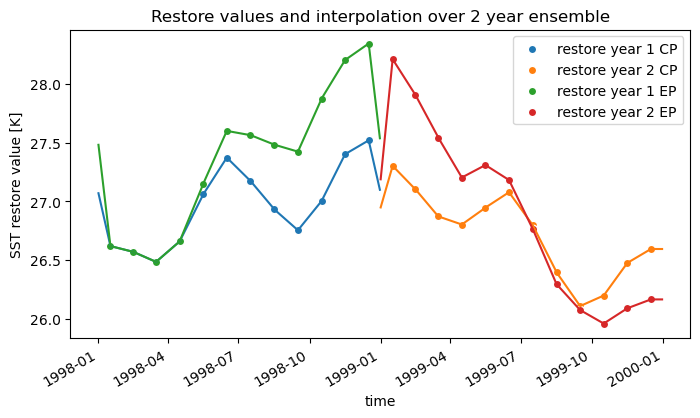

In [75]:
plt.figure(figsize = (8,4))
CP_n34_1.plot.scatter(label = "restore year 1 CP")
CP_n34_2.plot.scatter(label = "restore year 2 CP")

new_da_CP1.resample(time="1D").interpolate("linear").sel(time = slice("1998-01-01", "1998-12-31")).plot()
new_da2_CP2.resample(time="1D").interpolate("linear").sel(time = slice("1999-01-01", "1999-12-31")).plot()

EP_n34_1.plot.scatter(label = "restore year 1 EP")
EP_n34_2.plot.scatter(label = "restore year 2 EP")

new_da_EP1.resample(time="1D").interpolate("linear").sel(time = slice("1998-01-01", "1998-12-31")).plot()
new_da2_EP2.resample(time="1D").interpolate("linear").sel(time = slice("1999-01-01", "1999-12-31")).plot()
plt.title("Restore values and interpolation over 2 year ensemble")
plt.ylabel("SST restore value [K]")
plt.legend()